<a href="https://colab.research.google.com/github/zhus-dika/RL_home_works/blob/main/hw_2_dqn_cnn_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Q-Network CNN implementation

In [1]:
import sys, os
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/atari_wrappers.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/utils.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/framebuffer.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/prioritized_sampler.py

!pip -q install gymnasium[atari,accept-rom-license]

# !touch .setup_complete

# # This code creates a virtual display to draw game images on.
# # It will have no effect if your machine has a monitor.
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash ../xvfb start
#     os.environ['DISPLAY'] = ':1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import random
import numpy as np
import torch
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ENV_NAME = "BreakoutNoFrameskip-v4"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


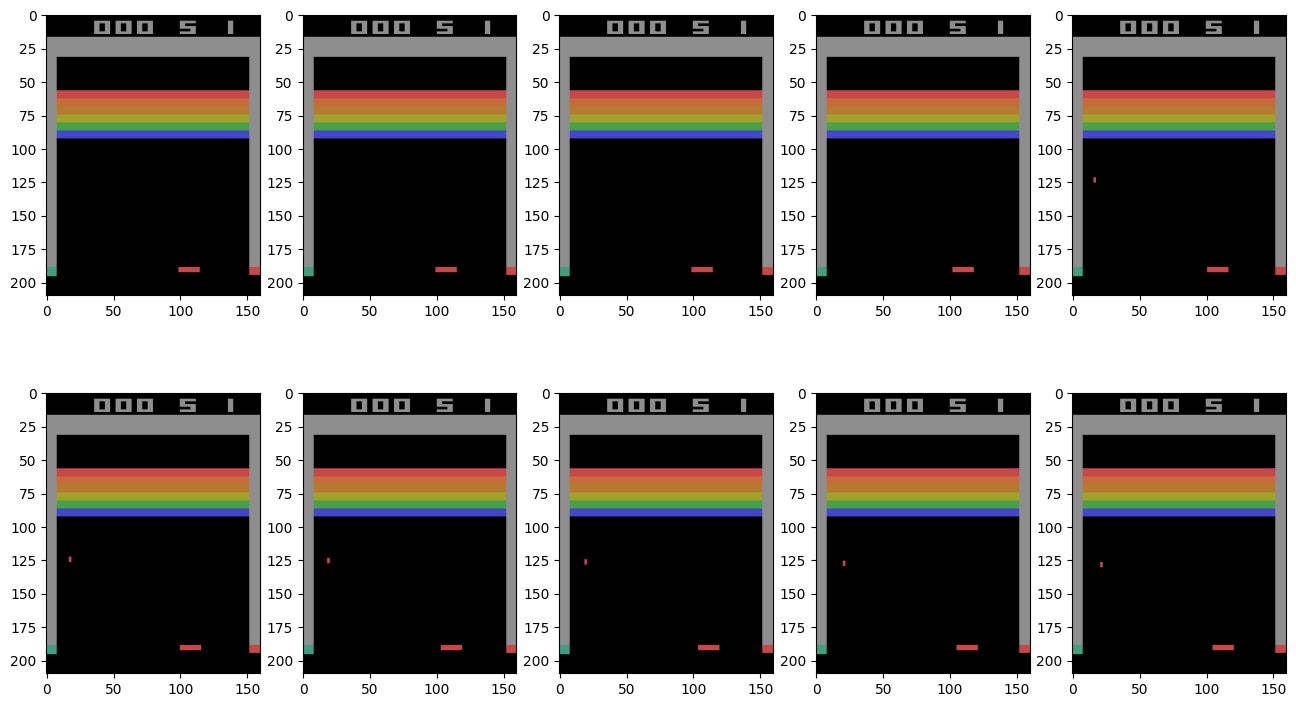

In [4]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

In [5]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        blue = rgb[:,:,0]
        green = rgb[:,:,1]
        red = rgb[:,:,2]
        res = np.expand_dims(channel_weights[0] * blue + channel_weights[1] * green + channel_weights[2] * red, axis=0)
        return res

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        # original image size 210x160
        img_crop = img[25:200, 5:154]
        obs = cv2.resize(
            img_crop,
            (self.img_size[1], self.img_size[2]),
            #interpolation=cv2.INTER_CUBIC
        )
        obs_gray = self._to_gray_scale(obs)
        obs_res = obs_gray.astype(np.float32) / 255.0
        return obs_res

Formal tests seem fine. Here's an example of what you'll get.


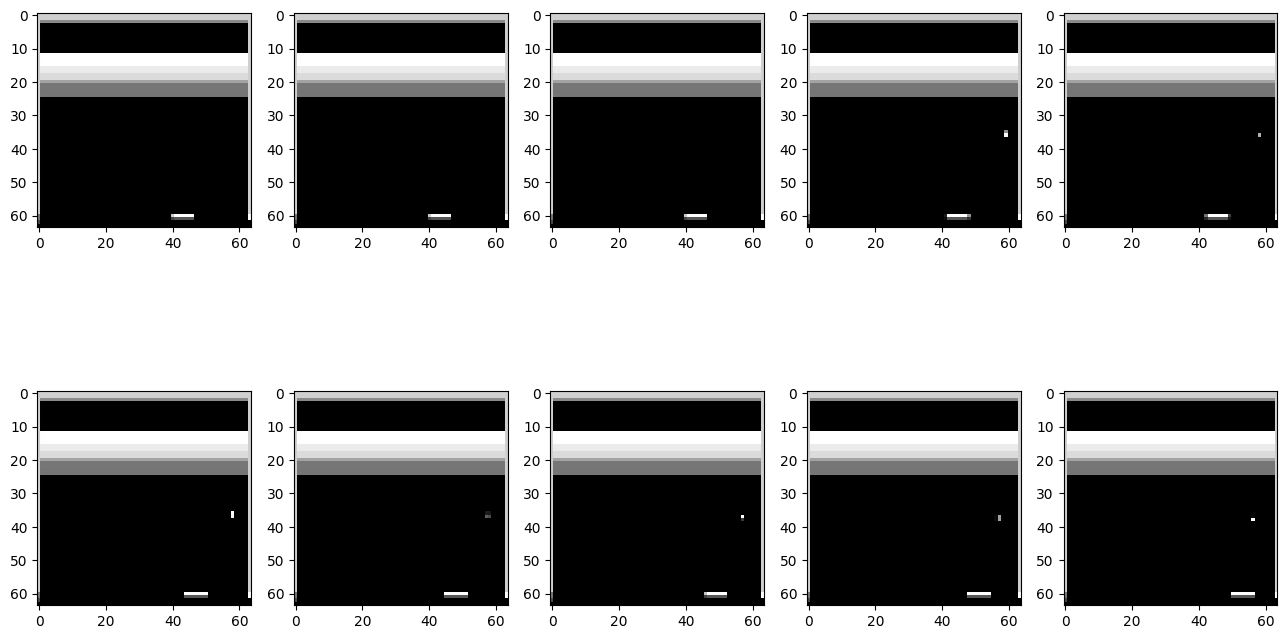

In [7]:
# spawn game instance for tests
env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"
assert np.max(obs) > 1. / 256, "you probably divided on 256 twice"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs, _ = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()

## Wrapping

In [8]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are given by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

## Frame Buffer


In [9]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

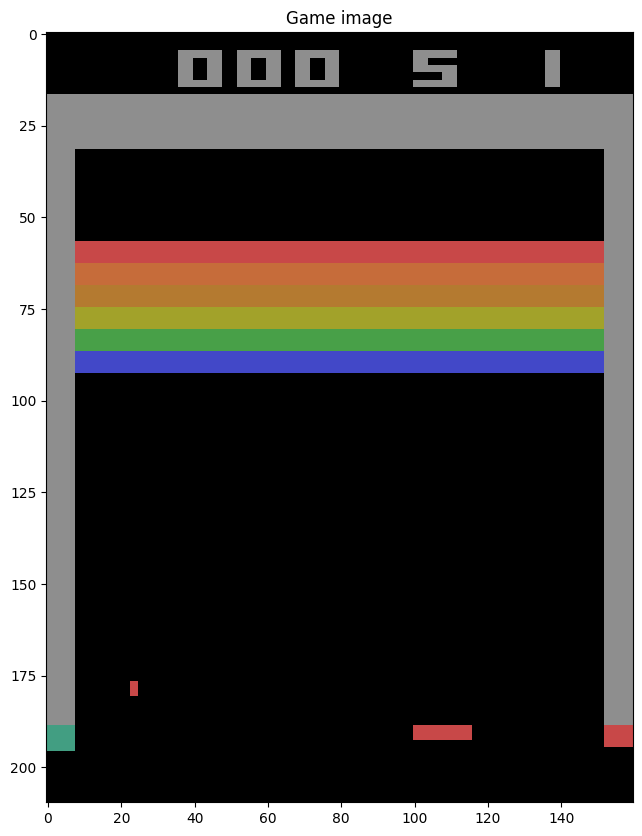

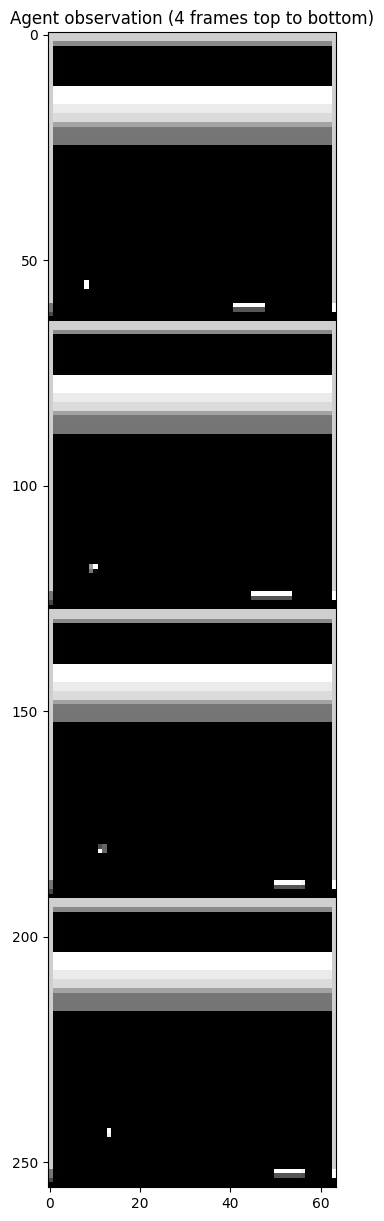

In [10]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

## DQN

In [11]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cpu')

In [12]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [13]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        cur_layer_img_w = conv2d_size_out(self.state_shape[1], 3, 2)
        cur_layer_img_h = conv2d_size_out(self.state_shape[2], 3, 2)

        cur_layer_img_w = conv2d_size_out(cur_layer_img_w, 3, 2)
        cur_layer_img_h = conv2d_size_out(cur_layer_img_h, 3, 2)

        cur_layer_img_w = conv2d_size_out(cur_layer_img_w, 3, 2)
        cur_layer_img_h = conv2d_size_out(cur_layer_img_h, 3, 2)
        # self.network = nn.Sequential(
        #     nn.Conv2d(4, 32, 8, stride=4),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, 4, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, stride=1),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(3136, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, env.single_action_space.n),
        # )

        self.network = nn.Sequential(
            nn.Conv2d(4, 16, 3, stride=2),
            # (64 - 3 + 2) / 2 = 31
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2),
            # (31 - 3 + 2) / 2 = 15
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2),
            # (15 - 3 + 2) / 2 = 7
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*cur_layer_img_w*cur_layer_img_h, 256),

            nn.ReLU(),
            nn.Linear(256, self.n_actions)
        )

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = self.network(state_t)
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [14]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [15]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [16]:
evaluate(env, agent, n_games=1)

<ipython-input-13-b53d40b9bb8f>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(states, device=model_device, dtype=torch.float)


0.0

## Experience Replay

In [17]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
        if maxsize == len(storage):
            storage.pop(0)
        storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
            # randomly generate batch_size integers
            # to be used as indexes of samples
        storage = self._storage
        ids_batch = np.random.choice(range(len(storage)), replace=False, size=batch_size)
        obs_batch = np.array([storage[i][0] for i in ids_batch])
        act_batch = np.array([storage[i][1] for i in ids_batch])
        rew_batch = np.array([storage[i][2] for i in ids_batch])
        next_obs_batch = np.array([storage[i][3] for i in ids_batch])
        done_mask = np.array([storage[i][4] for i in ids_batch])

        return (obs_batch, act_batch, rew_batch, next_obs_batch, done_mask)
            # <states>, <actions>, <rewards>, <next_states>, <is_done>

In [18]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [19]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_state, reward, terminated, truncated, _ = env.step(action)
        sum_rewards += reward
        if terminated or truncated:
            exp_replay.add(s, action, reward, next_state, True)
            s, _ = env.reset()
        else:
            exp_replay.add(s, action, reward, next_state, False)
            s = next_state
    return sum_rewards, s

In [20]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


## Target networks

In [21]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [22]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = target_network(next_states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
        range(states.shape[0]), actions
    ]

    # compute V*(next_states) using predicted next q-values
    next_state_values, _ = torch.max(predicted_next_qvalues, dim=1)

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.

    target_qvalues_for_actions = is_not_done * gamma * next_state_values + rewards

    assert target_qvalues_for_actions.requires_grad == False, "do not send gradients to target!"

    # mean squared error loss to minimize
    lossMSE = nn.MSELoss()
    loss = lossMSE(predicted_qvalues_for_actions, target_qvalues_for_actions)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [23]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [24]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

### Main loop

In [25]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [26]:
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [27]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm

exp_replay = ReplayBuffer(10**5)
for i in tqdm(range(1000)):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**5:
        break
print(len(exp_replay))

  0%|          | 0/1000 [00:00<?, ?it/s]

100000


In [32]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [ ]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 100000, epsilon = 0.51850


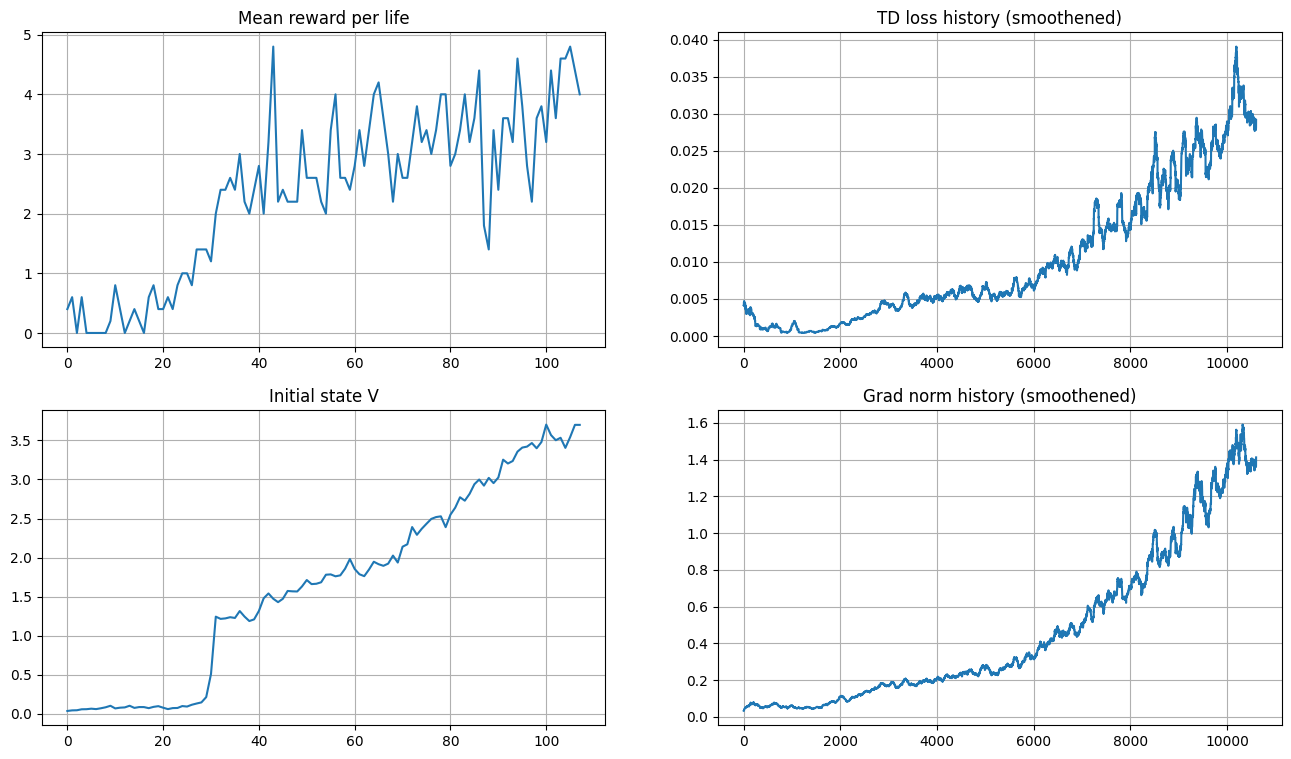

 18%|█▊        | 537895/3000001 [4:20:58<17:27:11, 39.19it/s]  

In [ ]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    # < sample batch_size of data from experience replay >
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    # loss = < compute TD loss >
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                           agent, target_network, gamma=0.99,)
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

In [ ]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 15, 'not as cool as DQN can'
print('Cool!')

final score: 29.0
Cool!


## Save and load model

In [ ]:
#torch.save(agent.state_dict(), './agent.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [30]:
agent.load_state_dict(torch.load('/content/drive/MyDrive/hse/RL/models/agent.pth', map_location=torch.device('cpu')))#

<All keys matched successfully>

## Record a video

In [ ]:
!pip install moviepy

In [33]:
# record sessions
from gymnasium.wrappers import RecordVideo

with RecordVideo(env=make_env(), video_folder='./videos',
                 episode_trigger = lambda episode_number: True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives,
                         greedy=True) for _ in range(10)]
env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-1.mp4


Moviepy - Building video /content/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-2.mp4
Moviepy - Building video /content/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-3.mp4


Moviepy - Building video /content/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-4.mp4


Moviepy - Building video /content/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-5.mp4


Moviepy - Building video /content/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-6.mp4
Moviepy - Building video /content/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-7.mp4
Moviepy - Building video /content/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-8.mp4


Moviepy - Building video /content/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-9.mp4


Moviepy - Building video /content/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-10.mp4
Moviepy - Building video /content/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-11.mp4


Moviepy - Building video /content/videos/rl-video-episode-12.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-12.mp4
Moviepy - Building video /content/videos/rl-video-episode-13.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-13.mp4


Moviepy - Building video /content/videos/rl-video-episode-14.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-14.mp4


Moviepy - Building video /content/videos/rl-video-episode-15.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-15.mp4
Moviepy - Building video /content/videos/rl-video-episode-16.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-16.mp4
Moviepy - Building video /content/videos/rl-video-episode-17.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-17.mp4
Moviepy - Building video /content/videos/rl-video-episode-18.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-18.mp4


Moviepy - Building video /content/videos/rl-video-episode-19.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-19.mp4


Moviepy - Building video /content/videos/rl-video-episode-20.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-20.mp4


Moviepy - Building video /content/videos/rl-video-episode-21.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-21.mp4


Moviepy - Building video /content/videos/rl-video-episode-22.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-22.mp4
Moviepy - Building video /content/videos/rl-video-episode-23.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-23.mp4
Moviepy - Building video /content/videos/rl-video-episode-24.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-24.mp4
Moviepy - Building video /content/videos/rl-video-episode-25.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-25.mp4
Moviepy - Building video /content/videos/rl-video-episode-26.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-26.mp4


Moviepy - Building video /content/videos/rl-video-episode-27.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-27.mp4
Moviepy - Building video /content/videos/rl-video-episode-28.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-28.mp4


Moviepy - Building video /content/videos/rl-video-episode-29.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-29.mp4


Moviepy - Building video /content/videos/rl-video-episode-30.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-30.mp4
Moviepy - Building video /content/videos/rl-video-episode-31.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-31.mp4


Moviepy - Building video /content/videos/rl-video-episode-32.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-32.mp4
Moviepy - Building video /content/videos/rl-video-episode-33.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-33.mp4
Moviepy - Building video /content/videos/rl-video-episode-34.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-34.mp4


Moviepy - Building video /content/videos/rl-video-episode-35.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-35.mp4


Moviepy - Building video /content/videos/rl-video-episode-36.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-36.mp4
Moviepy - Building video /content/videos/rl-video-episode-37.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-37.mp4
Moviepy - Building video /content/videos/rl-video-episode-38.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-38.mp4


Moviepy - Building video /content/videos/rl-video-episode-39.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-39.mp4


Moviepy - Building video /content/videos/rl-video-episode-40.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-40.mp4


Moviepy - Building video /content/videos/rl-video-episode-41.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-41.mp4
Moviepy - Building video /content/videos/rl-video-episode-42.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-42.mp4
Moviepy - Building video /content/videos/rl-video-episode-43.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-43.mp4


Moviepy - Building video /content/videos/rl-video-episode-44.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-44.mp4


Moviepy - Building video /content/videos/rl-video-episode-45.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-45.mp4


Moviepy - Building video /content/videos/rl-video-episode-46.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-46.mp4


Moviepy - Building video /content/videos/rl-video-episode-47.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-47.mp4
Moviepy - Building video /content/videos/rl-video-episode-48.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-48.mp4


Moviepy - Building video /content/videos/rl-video-episode-49.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-49.mp4


In [34]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Let's have a closer look at this (up to 1 point)

In [35]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 4.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


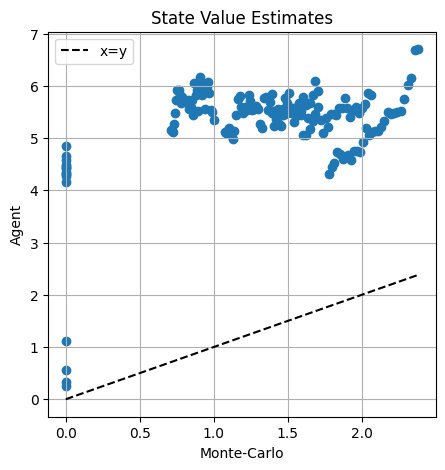

In [36]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

In [ ]:
from utils import play_and_log_episode, img_by_obs

<YOUR CODE>

### СПАСИБО ЗА ПРОВЕРКУ ДЗ!



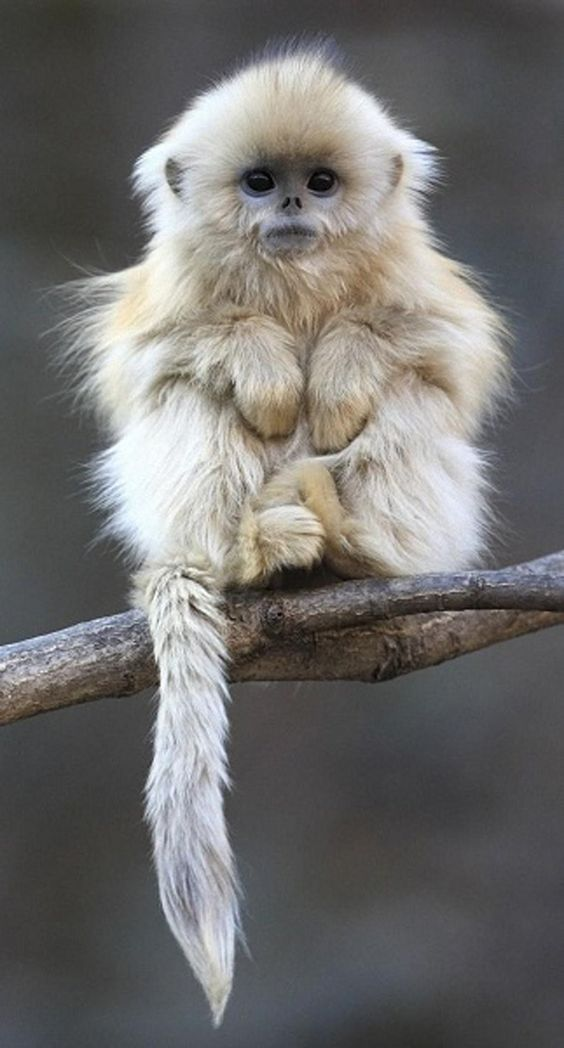